In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
root = '../data/raw/'

ecg_files = os.listdir(root + '/ECGDataDenoised')
print(ecg_files[:10])

['MUSE_20180120_123813_67000.csv', 'MUSE_20180114_131501_69000.csv', 'MUSE_20180114_070252_15000.csv', 'MUSE_20180112_120955_24000.csv', 'MUSE_20180210_123937_02000.csv', 'MUSE_20180118_135213_14000.csv', 'MUSE_20180113_135458_69000.csv', 'MUSE_20180113_130206_88000.csv', 'MUSE_20180113_125418_88000.csv', 'MUSE_20180113_075147_58000.csv']


In [3]:
attributes_dictionary = pd.read_excel(root + '/AttributesDictionary.xlsx')
attributes_dictionary.head()

,Attributes,Type,ValueRange,Description
0,FileName,String,NaN,ECG data file name(unique ID)
1,Rhythm,String,NaN,Rhythm Label
2,Beat,String,NaN,Other conditions Label
3,PatientAge,Numeric,0-999,Age
4,DateofBirth,Date,NaN,Date of Birth


In [4]:
condition_names = pd.read_excel(root + '/ConditionNames.xlsx')
condition_names.head()

,Acronym Name,Full Name
0,1AVB,1 degree atrioventricular block
1,2AVB,2 degree atrioventricular block
2,2AVB1,2 degree atrioventricular block(Type one)
3,2AVB2,2 degree atrioventricular block(Type two)
4,3AVB,3 degree atrioventricular block


In [5]:
diagnostics = pd.read_excel(root + '/Diagnostics.xlsx')
diagnostics.head()

,FileName,Rhythm,Beat,PatientAge,DateofBirth,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,01-01-1932,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,01-01-1958,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,01-01-1996,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,01-01-1951,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,01-01-1943,FEMALE,162,162,114,252,413,68,-40,26,228,285,354


### !Please check the R script for exploration on the diagnostics!

#### Remove files with deleted labels from file vector 

In [6]:
len(ecg_files)

10646

In [7]:
drop_label = ['AF', 'AVRT', 'SA', 'SAAWR']
diagnostics_new = diagnostics[~diagnostics['Rhythm'].isin(drop_label)]
len(diagnostics_new)

9787

In [8]:
diagnostics_new.isna().sum()

FileName           0
Rhythm             0
Beat               0
PatientAge         0
DateofBirth        0
Gender             0
VentricularRate    0
AtrialRate         0
QRSDuration        0
QTInterval         0
QTCorrected        0
RAxis              0
TAxis              0
QRSCount           0
QOnset             0
QOffset            0
TOffset            0
dtype: int64

#### Obtain file list and use this to sort out faulty records

Indices in the data matrix will correspond to indices in the file name list.
In the final script faulty files won't be loaded.

In [9]:
file_list = diagnostics_new['FileName'].tolist()
file_list.sort()

In [10]:
ecg_graphs = []
for idx, file in enumerate(tqdm(file_list)):
    ecg = np.genfromtxt(os.path.join(root + '/ECGDataDenoised', file + '.csv'), delimiter=',')
    if ecg.shape != (5000, 12):
        print(ecg.shape, file, idx)
    else:
        ecg = np.expand_dims(ecg, axis=0)
        ecg_graphs.append(ecg)
    
ecg_graphs = np.concatenate(ecg_graphs)
print(ecg_graphs.shape)

 18%|█▊        | 1755/9787 [01:08<04:56, 27.07it/s]

(1926, 12) MUSE_20180113_124215_52000 1749


100%|██████████| 9787/9787 [06:21<00:00, 25.69it/s]


(9786, 5000, 12)


#### Serves as checkpoint

In [11]:
with open('../data/raw/ecgs_raw.pkl', 'wb') as handle:
    pickle.dump(ecg_graphs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
with open('../data/raw/ecgs_raw.pkl', 'rb') as handle:
    ecg_graphs = pickle.load(handle)

#### Check for NaNs

In [13]:
np.count_nonzero(np.isnan(ecg_graphs))

149370

In [14]:
# Percentage of Nans to total values
(np.count_nonzero(np.isnan(ecg_graphs)) / (ecg_graphs.shape[0] * ecg_graphs.shape[1] * ecg_graphs.shape[2])) * 100

0.0254394032291028

In [15]:
# Are complete entries NaNs?
for i in range(len(ecg_graphs)):
    not_nan = np.count_nonzero(~np.isnan(ecg_graphs[i]))
    if not_nan == 0:
        print(i)

In [16]:
# Are some series NaN?
for i in range(ecg_graphs.shape[0]):
    for j in range(ecg_graphs.shape[2]):
        not_nan = np.count_nonzero(~np.isnan(ecg_graphs[i,:,j]))
        if not_nan == 0:
            print('Entry: {}; Sensor: {}'.format(i, j))

No? Perfect

In [17]:
# Are 30% of values in some series NaN?
for i in range(ecg_graphs.shape[0]):
    for j in range(ecg_graphs.shape[2]):
        nan = np.count_nonzero(np.isnan(ecg_graphs[i,:,j]))
        if nan > 0.2 * 5000 :
            print('Entry: {}; Sensor: {}'.format(i, j))

Entry: 2435; Sensor: 6
Entry: 2435; Sensor: 7
Entry: 2435; Sensor: 8
Entry: 2435; Sensor: 9
Entry: 2435; Sensor: 10
Entry: 2435; Sensor: 11
Entry: 2464; Sensor: 6
Entry: 2464; Sensor: 7
Entry: 2464; Sensor: 8
Entry: 2464; Sensor: 9
Entry: 2464; Sensor: 10
Entry: 2464; Sensor: 11
Entry: 7166; Sensor: 6
Entry: 7166; Sensor: 7
Entry: 7166; Sensor: 8
Entry: 7166; Sensor: 9
Entry: 7166; Sensor: 10
Entry: 7166; Sensor: 11
Entry: 7343; Sensor: 6
Entry: 7343; Sensor: 7
Entry: 7343; Sensor: 8
Entry: 7343; Sensor: 9
Entry: 7343; Sensor: 10
Entry: 7343; Sensor: 11
Entry: 9129; Sensor: 7
Entry: 9129; Sensor: 9
Entry: 9129; Sensor: 11
Entry: 9483; Sensor: 11
Entry: 9485; Sensor: 7
Entry: 9488; Sensor: 11


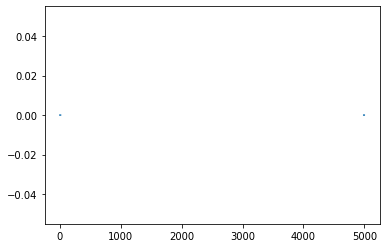

In [4]:
plt.plot(ecg_graphs[2435,:,6])

In [7]:
# Do some sensors only report one value (or is the sensor dead)?
stds = []
for i in range(ecg_graphs.shape[0]):
    for j in range(ecg_graphs.shape[2]):
        std = np.std(ecg_graphs[i,:,j])
        stds.append(std)
        if std == 0 :
            print('Entry: {}; Sensor: {}'.format(i, j))

Entry: 9746; Sensor: 0
Entry: 9746; Sensor: 1
Entry: 9746; Sensor: 2
Entry: 9746; Sensor: 3
Entry: 9746; Sensor: 4
Entry: 9746; Sensor: 5
Entry: 9746; Sensor: 6
Entry: 9746; Sensor: 7
Entry: 9746; Sensor: 8
Entry: 9746; Sensor: 9
Entry: 9746; Sensor: 10
Entry: 9746; Sensor: 11
Entry: 9747; Sensor: 0
Entry: 9747; Sensor: 1
Entry: 9747; Sensor: 2
Entry: 9747; Sensor: 3
Entry: 9747; Sensor: 4
Entry: 9747; Sensor: 5
Entry: 9747; Sensor: 6
Entry: 9747; Sensor: 7
Entry: 9747; Sensor: 8
Entry: 9747; Sensor: 9
Entry: 9747; Sensor: 10
Entry: 9747; Sensor: 11
Entry: 9748; Sensor: 0
Entry: 9748; Sensor: 1
Entry: 9748; Sensor: 2
Entry: 9748; Sensor: 3
Entry: 9748; Sensor: 4
Entry: 9748; Sensor: 5
Entry: 9748; Sensor: 6
Entry: 9748; Sensor: 7
Entry: 9748; Sensor: 8
Entry: 9748; Sensor: 9
Entry: 9748; Sensor: 10
Entry: 9748; Sensor: 11
Entry: 9749; Sensor: 0
Entry: 9749; Sensor: 1
Entry: 9749; Sensor: 2
Entry: 9749; Sensor: 3
Entry: 9749; Sensor: 4
Entry: 9749; Sensor: 5
Entry: 9749; Sensor: 6
Entry

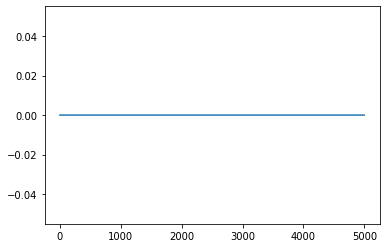

In [8]:
plt.plot(ecg_graphs[9747,: ,7])
plt.show()

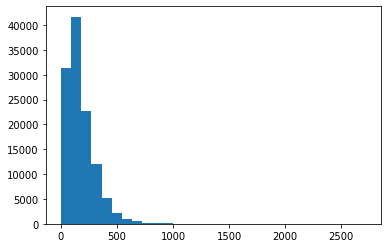

In [12]:
plt.hist(stds, bins=30)
plt.show()

In [20]:
# Are extreme outliers in the data?
print(np.nanmin(ecg_graphs))
print(np.nanmax(ecg_graphs))

-16721.0
20584.0


In [30]:
# What entries are responsible for these crazy values?
for i in range(ecg_graphs.shape[0]):
    for j in range(ecg_graphs.shape[2]):
        min = np.nanmin(ecg_graphs[i,:,j])
        max = np.nanmax(ecg_graphs[i,:,j])
        if min < -5000 or max > 5000 :
            print('Entry: {}; Sensor: {}'.format(i, j))

Entry: 4; Sensor: 8
Entry: 4; Sensor: 11
Entry: 10; Sensor: 10
Entry: 10; Sensor: 11
Entry: 53; Sensor: 7
Entry: 53; Sensor: 8
Entry: 64; Sensor: 8
Entry: 77; Sensor: 11
Entry: 188; Sensor: 9
Entry: 188; Sensor: 10
Entry: 194; Sensor: 7
Entry: 252; Sensor: 8
Entry: 308; Sensor: 7
Entry: 308; Sensor: 8
Entry: 308; Sensor: 10
Entry: 309; Sensor: 10
Entry: 352; Sensor: 10
Entry: 396; Sensor: 7
Entry: 405; Sensor: 8
Entry: 405; Sensor: 10
Entry: 492; Sensor: 7
Entry: 492; Sensor: 8
Entry: 493; Sensor: 8
Entry: 494; Sensor: 7
Entry: 494; Sensor: 8
Entry: 764; Sensor: 10
Entry: 819; Sensor: 11
Entry: 931; Sensor: 9
Entry: 964; Sensor: 7
Entry: 1151; Sensor: 8
Entry: 1151; Sensor: 9
Entry: 1192; Sensor: 10
Entry: 1192; Sensor: 11
Entry: 1292; Sensor: 10
Entry: 1395; Sensor: 9
Entry: 1524; Sensor: 7
Entry: 1524; Sensor: 8
Entry: 1588; Sensor: 10
Entry: 1598; Sensor: 10
Entry: 1620; Sensor: 8
Entry: 1620; Sensor: 9
Entry: 1620; Sensor: 11
Entry: 1673; Sensor: 10
Entry: 1677; Sensor: 11
Entry: 1

The list indicates a lot of unsuspected high readings. I don't have enough domain knowledge to sort measure errors from real anomalies. Therefore I raise the max/min level to 10k.

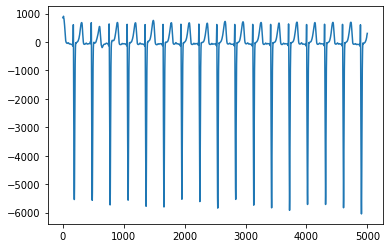

In [33]:
plt.plot(ecg_graphs[4, : ,8])
plt.show()

In [34]:
for i in range(ecg_graphs.shape[0]):
    for j in range(ecg_graphs.shape[2]):
        min = np.nanmin(ecg_graphs[i,:,j])
        max = np.nanmax(ecg_graphs[i,:,j])
        if min < -10000 or max > 10000 :
            print('Entry: {}; Sensor: {}'.format(i, j))

Entry: 64; Sensor: 8
Entry: 308; Sensor: 7
Entry: 1681; Sensor: 9
Entry: 1969; Sensor: 9
Entry: 3654; Sensor: 9
Entry: 3654; Sensor: 10
Entry: 4587; Sensor: 0
Entry: 5524; Sensor: 8
Entry: 6455; Sensor: 8
Entry: 6655; Sensor: 10
Entry: 6655; Sensor: 11
Entry: 7139; Sensor: 9
Entry: 8141; Sensor: 9
Entry: 8539; Sensor: 10
Entry: 8539; Sensor: 11
Entry: 9385; Sensor: 11
Entry: 9430; Sensor: 8
Entry: 9498; Sensor: 10
Entry: 9688; Sensor: 10


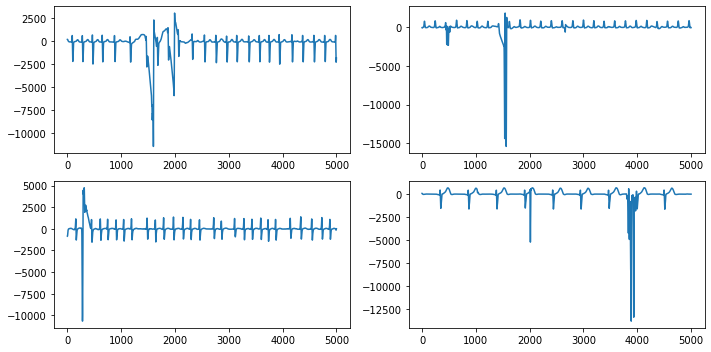

In [47]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.plot(ecg_graphs[64, : ,8])
plt.subplot(2, 2, 2)
plt.plot(ecg_graphs[9498, : ,10])
plt.subplot(2, 2, 3)
plt.plot(ecg_graphs[7139, : ,9])
plt.subplot(2, 2, 4)
plt.plot(ecg_graphs[308, : ,7])
fig.tight_layout()
plt.savefig('../plots/outlier.pdf')
plt.show()

## Clean data matrix

In [3]:
# Collected indices:

idx_remove = set([64, 308, 1681, 1969, 3654, 4587, 5524, 6455, 6655, 7139, 8141, 8539, 9385, 9430, 9498, 2435, 2464, 7166, 7343, 9129, 9483, 9485, 9488, 9746, 9747, 9748, 9749, 9750, 9751, 9752, 9753, 9754, 9755, 9756, 9757, 9758, 9759, 9760, 9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784])
idx_remove = list(idx_remove)
idx_remove.sort()
print(idx_remove)

[64, 308, 1681, 1969, 2435, 2464, 3654, 4587, 5524, 6455, 6655, 7139, 7166, 7343, 8141, 8539, 9129, 9385, 9430, 9483, 9485, 9488, 9498, 9746, 9747, 9748, 9749, 9750, 9751, 9752, 9753, 9754, 9755, 9756, 9757, 9758, 9759, 9760, 9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784]


In [9]:
mask = np.ones(ecg_graphs.shape[0], dtype=bool)
mask[idx_remove] = False
ecg_new = ecg_graphs[mask]

print(ecg_new.shape)



(9724, 5000, 12)


In [11]:
# Percentage of Nans to total values
(np.count_nonzero(np.isnan(ecg_new)) / (ecg_new.shape[0] * ecg_new.shape[1] * ecg_new.shape[2])) * 100

0.0